In [2]:
# Dependencies
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import lib.RANSAC as rn

In [3]:
# Question 01 : Circle fitting RANSAC

# np.random.seed(0)
N=100
half_n=N//2
r=10
s=r/16
t=np.random.uniform(0,2*np.pi,half_n)
n=s*np.random.randn(half_n)
x,y=(r+n)*np.cos(t),(r+n)*np.sin(t)
x_circ = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
m,b=1,2
x=np.linspace(-12,12,half_n)
y=n*x+b+s*np.random.randn(half_n)
x_line=np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
X=np.vstack((x_circ,x_line))


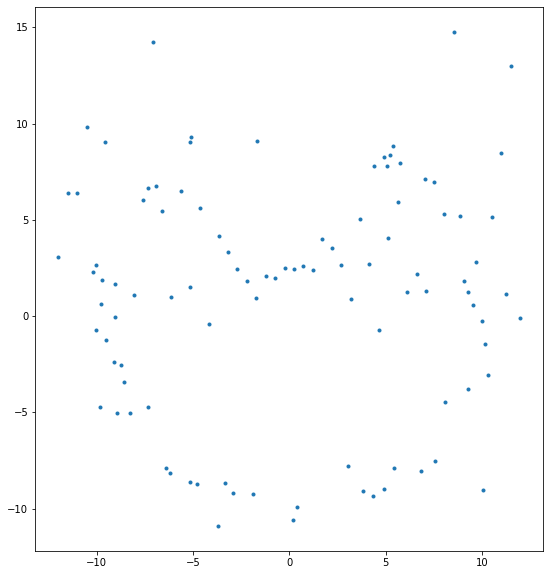

In [11]:
rn.visualize_points([X],fig_size=(20,10))